# Analisis de regresion: prediccion del exito de bandas musicales

Se cuenta con un conjunto de eventos realizados el mes de abril en Estados Unidos. Para cada uno de estos eventos se cuenta con el resultado de éstos, a través del número de tickets y el porcentaje de ocupación del lugar del evento. Es este indicador, el porcentaje, el valor que constituirá la variable dependiente del problema.

### Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn_pandas as sp
import sys
import copy
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

### Carga de datos

In [2]:
dataset = pd.read_csv('/home/dgomez/rrss_final.csv')
print "count: " + str(dataset['tickets'].count())
print "mean: " + str(dataset['tickets'].mean())
print "std: " + str(dataset['tickets'].std())
dataset = dataset.replace(np.NaN, 0)
total = len(dataset)
size = int(0.90 * total)

count: 1243
mean: 81.34111021721641
std: 23.539793444654286


### Preparacion de variables
Se procede a normalizar cada una de las variables. En particular, dayofweek, al ser una variable categorica, se trata de una manera especial: se convierte en 7 variables binarias.

In [3]:
mapper = sp.DataFrameMapper([
    ('dayofweek', LabelBinarizer()),
    (['state_pob', 'capacity', 'price', 'facebook_likes', 'youtube_suscrs', 'youtube_views',
    'instagram_folls', 'instagram_likes', 'spotify_folls', 'spotify_pop',
    'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
     'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec'], StandardScaler())
    ])
X = dataset[['dayofweek', 'state_pob', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs', 'youtube_views',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec']]
Xy = dataset[['dayofweek', 'state_pob', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs', 'youtube_views',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec', 'tickets']]

X = mapper.fit_transform(X) # numpy.ndarray
y = dataset['tickets'] # dataframe

### Descripcion de variables
A continuacion, se presenta un resumen de las variables del dataset.

In [4]:
Xy.columns

Index([u'dayofweek', u'state_pob', u'capacity', u'price', u'facebook_likes',
       u'youtube_suscrs', u'youtube_views', u'instagram_folls',
       u'instagram_likes', u'spotify_folls', u'spotify_pop', u'twitter_folls',
       u'twitter_mencs_usa', u'twitter_mencs', u'facebook_crec',
       u'youtube_crec', u'instagram_crec', u'twitter_crec', u'tickets'],
      dtype='object')

In [5]:
Xy[0:10]

,dayofweek,state_pob,capacity,price,facebook_likes,youtube_suscrs,youtube_views,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
0,2,18801310,896,32.5,22996,4421,1387393,1607,687,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,100
1,3,18801310,464,57.0,22996,4421,1387393,1607,687,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,70
2,6,6547629,953,29.5,220997,5198269,145192066,7400000,36753,3268169.0,84.0,12503006,430,1000,-5.121,0.271,0.000,0.063,100
3,2,6483802,1417,52.5,794140,249144,114306783,131300,30825,184851.0,57.0,88664,52,58,1.916,1.443,0.458,0.082,98
4,4,38332521,1000,10.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,67
5,5,38332521,10000,37.5,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,100
6,3,3831074,1270,28.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,55
7,5,38332521,600,12.5,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,100
8,4,4533372,1300,17.5,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,40
9,2,6724540,500,40.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,97


In [6]:
Xy.describe().round(decimals=2)

,dayofweek,state_pob,capacity,price,facebook_likes,youtube_suscrs,youtube_views,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
count,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1.243000e+03,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00
mean,3.40,12995981.75,2759.76,49.19,276629.64,901045.27,3.108223e+07,1820867.22,93569.16,679226.89,48.17,2290708.34,227.12,294.34,-0.48,2.07,1.13,0.32,81.34
std,1.73,10132292.10,4801.53,54.55,277638.11,2511135.63,1.386564e+08,8187097.71,295849.33,1647687.53,21.95,9316080.35,337.47,377.96,5.37,13.62,1.38,0.96,23.54
min,0.00,601723.00,40.00,2.25,625.00,0.00,9.100000e+01,26.00,0.00,0.00,0.00,4.00,0.00,0.00,-60.47,-127.70,-1.52,-13.42,5.00
25%,2.00,5686986.00,500.00,19.00,48095.00,3292.00,1.979805e+05,17700.00,2019.50,17138.00,37.00,12184.50,13.00,17.00,-0.08,0.38,0.28,-0.03,64.00
50%,4.00,9687653.00,1175.00,33.50,169258.00,27828.00,1.842684e+06,70000.00,7804.00,93235.00,52.00,50871.00,59.00,85.00,0.03,0.94,0.81,0.13,96.00
75%,5.00,19378102.00,2499.00,59.62,464989.00,380507.50,1.554856e+07,342100.00,27718.50,472259.00,64.00,364876.00,238.00,414.00,0.23,2.48,1.64,0.36,100.00
max,6.00,38332521.00,55292.00,713.00,983249.00,29920049.00,4.015486e+09,77500000.00,2864000.00,11070064.00,90.00,64194259.00,1000.00,1000.00,65.39,100.00,16.90,14.12,100.00


### Analisis de dispersion

Ahora se analizan los graficos de dispersion entre cada par de variables.

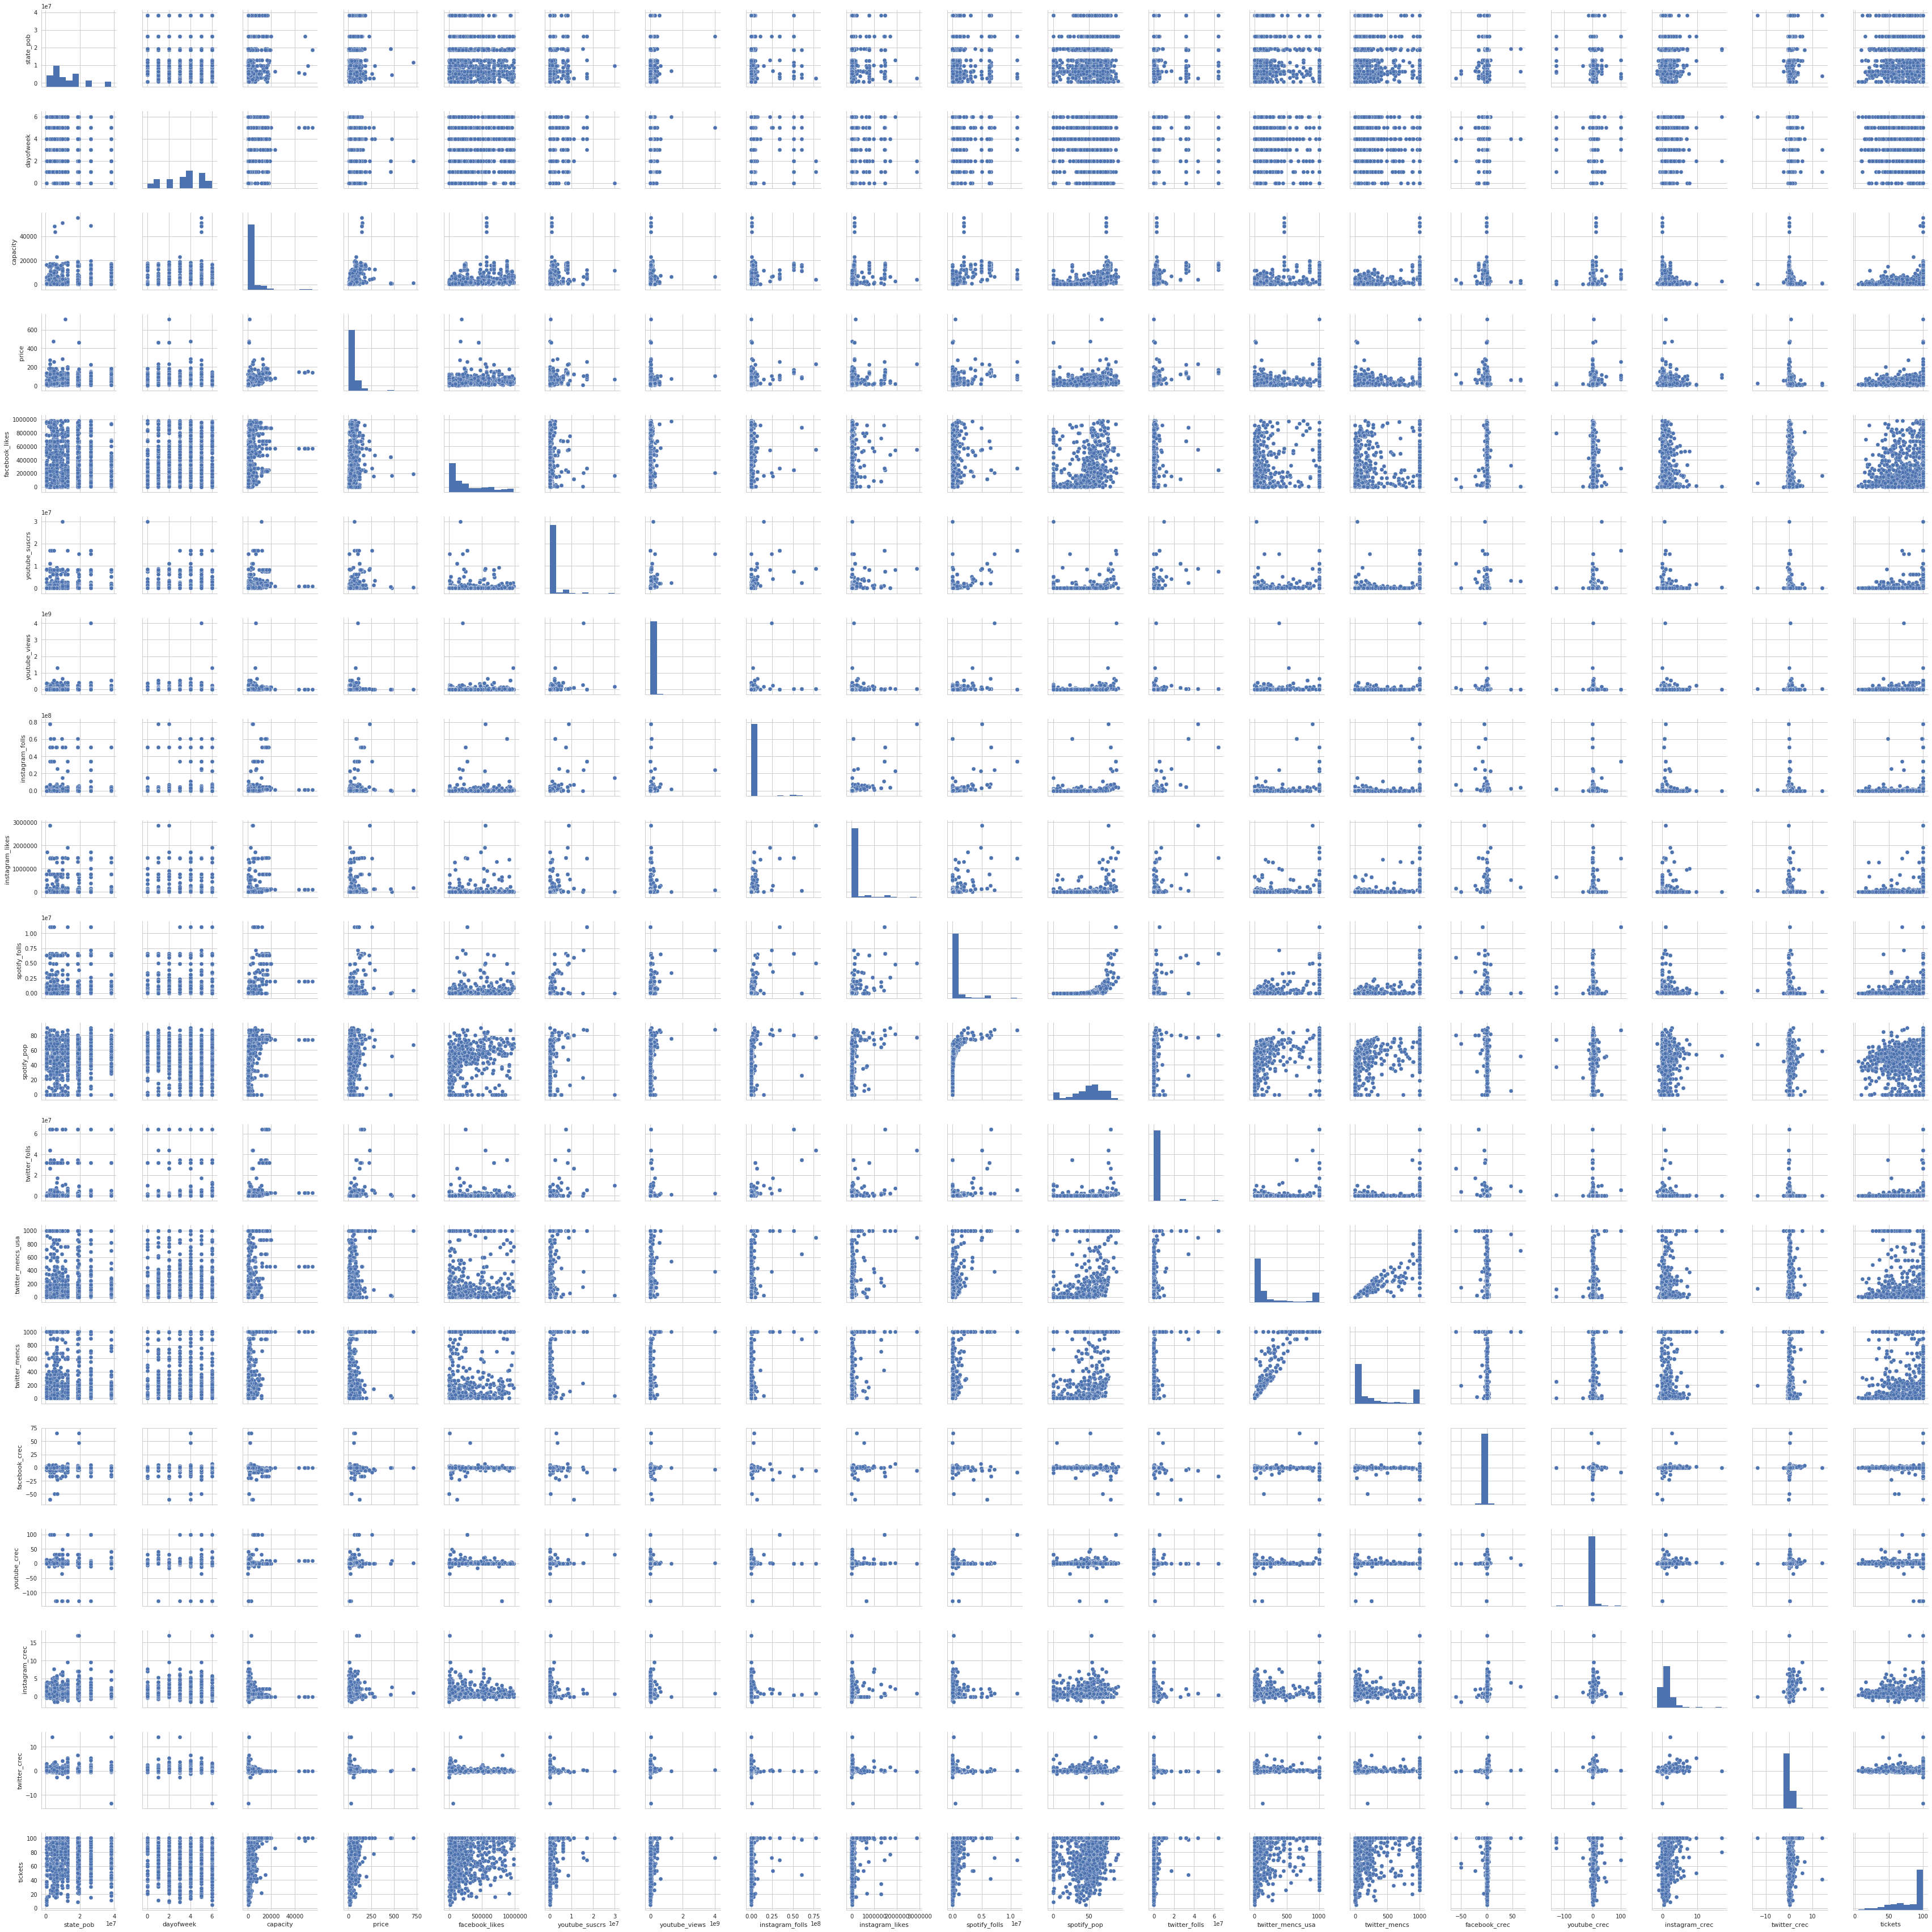

In [22]:
data_df = pd.DataFrame(Xy, columns=['state_pob', 'dayofweek', 'capacity', 'price', 'facebook_likes','youtube_suscrs','youtube_views','instagram_folls','instagram_likes','spotify_folls','spotify_pop','twitter_folls','twitter_mencs_usa','twitter_mencs','facebook_crec','youtube_crec','instagram_crec','twitter_crec','tickets'])
sns.set(style='whitegrid', context='notebook')
features_plot = data_df.columns
data_df[0:10]
sns.pairplot(data_df)#, kind='reg')#, size=2.0);
plt.tight_layout()

A continuacion, se analiza la dispersion entre cada una de las variables independientes y la variable dependiente "tickets".

KeyError: 'dayofweek_3'

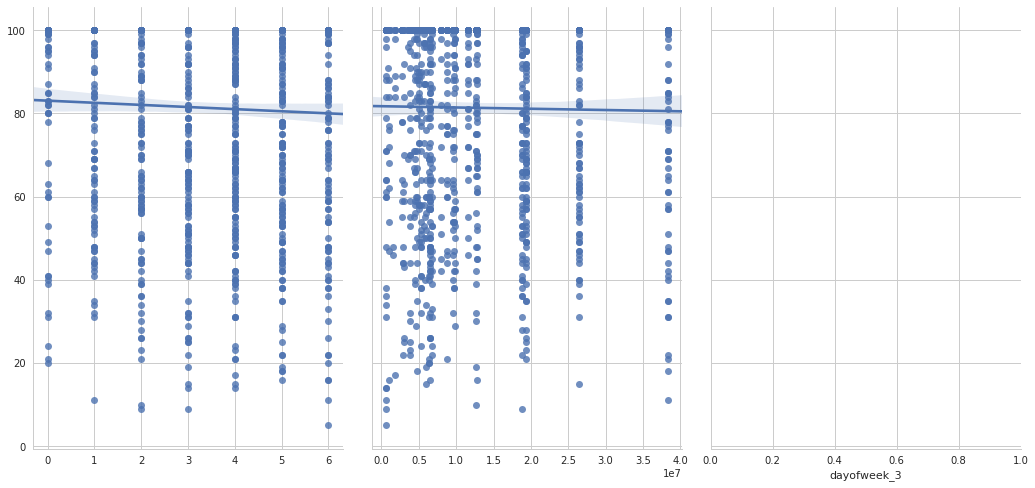

In [30]:
for i in range(1, len(dataset.columns) - 2, 3):
    sns.pairplot(dataset, x_vars= [dataset.columns[i], dataset.columns[i + 1], data.columns[i + 2]], y_vars='tickets', size=7, aspect=0.7, kind='reg')

### Analisis de correlacion

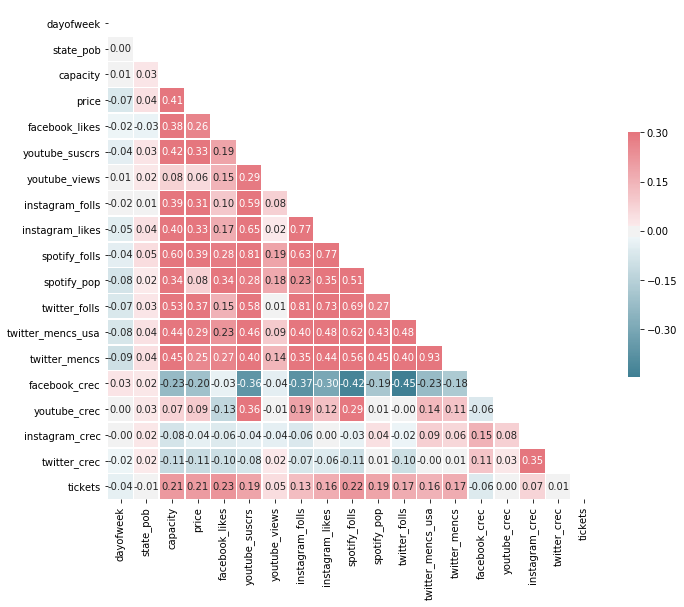

In [7]:
corr_vectors = Xy.corr()
mask = np.zeros_like(corr_vectors, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_vectors, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

# Pruebas de modelos

## RandomForest v/s MLP v/s gradient boosting

In [24]:
#tratatamiento de variables categoricas
dummies = pd.get_dummies(dataset['dayofweek'], prefix = 'dayofweek')
data = pd.concat([dummies, dataset], axis=1)
data = data.drop(['dayofweek', 'name'], axis=1)
data.head()

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,state_pob,capacity,price,...,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
0,0,0,1,0,0,0,0,18801310,896,32.5,...,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,100
1,0,0,0,1,0,0,0,18801310,464,57.0,...,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,70
2,0,0,0,0,0,0,1,6547629,953,29.5,...,3268169.0,84.0,12503006,430,1000,-5.121,0.271,0.000,0.063,100
3,0,0,1,0,0,0,0,6483802,1417,52.5,...,184851.0,57.0,88664,52,58,1.916,1.443,0.458,0.082,98
4,0,0,0,0,1,0,0,38332521,1000,10.0,...,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,67


In [25]:
#separacion features
nombres_col=list(data.columns)
X = data[nombres_col[0:-1]]
y = data[nombres_col[-1]]

###  Raund 1: RandomForest v/s MLP

In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

In [27]:
exp_MLP=[]
exp_RF=[]
kf = KFold(n_splits=5,shuffle=True)
for i in range(10):
    resultados_RF=[]
    resultados_MLP=[]
    X=np.array(X)

   
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        
        #prediccion con random forest
        rf_reg = RandomForestRegressor()
        rf_reg.fit(X_train,y_train)        
        rf_y_pred = rf_reg.predict(X_test)
        
        #prediccion con red neuronal
        clf = MLPRegressor(hidden_layer_sizes = (90,), activation = 'logistic', solver = 'sgd', warm_start = False)
        scaler = StandardScaler()  
        scaler.fit(X_train)  
        X_train = scaler.transform(X_train)  
        X_test = scaler.transform(X_test)          
        clf.fit(X_train,y_train)
        mlp_y_pred=clf.predict(X_test)
        
        
        resultados_RF.append(mean_squared_error(y_test,rf_y_pred))
        resultados_MLP.append(mean_squared_error(y_test,mlp_y_pred))
        
    #print ("Resultado MLP: ",resultados_MLP)
    print ("Promedio MLP: ",np.mean(resultados_MLP))
    #print ("Resultado RandomForest: ",resultados_RF)
    print ("Promedio RandomForest: ",np.mean(resultados_RF))
    
    exp_MLP.append(np.mean(resultados_MLP))
    exp_RF.append(np.mean(resultados_RF))


('Promedio MLP: ', 493.7449956611179)
('Promedio RandomForest: ', 445.915539707216)
('Promedio MLP: ', 496.77575289662207)
('Promedio RandomForest: ', 469.1937384376215)
('Promedio MLP: ', 489.80013253489244)
('Promedio RandomForest: ', 459.1190749125535)
('Promedio MLP: ', 490.12365784591304)
('Promedio RandomForest: ', 440.6292567690115)
('Promedio MLP: ', 486.5961248078156)
('Promedio RandomForest: ', 451.34507478300304)
('Promedio MLP: ', 495.06911608652337)
('Promedio RandomForest: ', 432.73385538929904)
('Promedio MLP: ', 485.5863980170041)
('Promedio RandomForest: ', 439.772593373494)
('Promedio MLP: ', 492.1721426556495)
('Promedio RandomForest: ', 454.2344975385413)
('Promedio MLP: ', 496.3778579947269)
('Promedio RandomForest: ', 433.95531396553963)
('Promedio MLP: ', 492.25418745066116)
('Promedio RandomForest: ', 459.994187589066)


In [28]:
print(exp_MLP)
print(exp_RF)
print("Promedio Experimentos MLP: ", np.mean(exp_MLP),"STD",np.std(exp_MLP))
print("Promedio Experimentos Random Forest Regressor: ", np.mean(exp_RF),"STD",np.std(exp_RF))

[493.7449956611179, 496.77575289662207, 489.80013253489244, 490.12365784591304, 486.5961248078156, 495.06911608652337, 485.5863980170041, 492.1721426556495, 496.3778579947269, 492.25418745066116]
[445.915539707216, 469.1937384376215, 459.1190749125535, 440.6292567690115, 451.34507478300304, 432.73385538929904, 439.772593373494, 454.2344975385413, 433.95531396553963, 459.994187589066]
('Promedio Experimentos MLP: ', 491.85003659509266, 'STD', 3.64696487670989)
('Promedio Experimentos Random Forest Regressor: ', 448.6893132465345, 'STD', 11.483236897787611)


In [29]:
from scipy import stats
t2, p2 = stats.ttest_ind(exp_MLP,exp_RF)
print("t = " + str(t2))
print("p = " + str(p2))
if p2<0.05:
    print("We reject the NULL Hypothesis. The differences are statistically significant!")
else:
    print("We cannot reject the NULL Hypothesis. The differences are NOT statistically significant!")

t = 10.746793073606979
p = 2.915470457316146e-09
We reject the NULL Hypothesis. The differences are statistically significant!


Ganador: RandomForest

###  Raund 2: RandomForest vs gradientboosting

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
exp_GRB=[]
exp_RF=[]
kf = KFold(n_splits=5,shuffle=True)
for i in range(10):
    resultados_RF=[]
    resultados_GRB=[]
    X=np.array(X)

   
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        
        #prediccion con random Forest
        rf_reg = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, oob_score=True, n_jobs=4)
        rf_reg.fit(X_train,y_train)        
        rf_y_pred = rf_reg.predict(X_test)
        
        #prediccion con gradient boosting
        grd_boosting = GradientBoostingRegressor(loss='huber', criterion='mse')       
        grd_boosting.fit(X_train,y_train)
        grb_y_pred=grd_boosting.predict(X_test)
        
        
        resultados_RF.append(mean_squared_error(y_test,rf_y_pred))
        resultados_GRB.append(mean_squared_error(y_test,grb_y_pred))
        
    #print ("Resultado GradientBoostingRegressor: ",resultados_GRB)
    print ("Promedio GradientBoostingRegressor: ",np.mean(resultados_GRB))
    #print ("Resultado RandomForest: ",resultados_RF)
    print ("Promedio RandomForest: ",np.mean(resultados_RF))
    
    exp_GRB.append(np.mean(resultados_GRB))
    exp_RF.append(np.mean(resultados_RF))


('Promedio GradientBoostingRegressor: ', 414.23259911341864)
('Promedio RandomForest: ', 410.36712523351764)
('Promedio GradientBoostingRegressor: ', 414.17444180723976)
('Promedio RandomForest: ', 408.3647177021252)
('Promedio GradientBoostingRegressor: ', 414.00460556842575)
('Promedio RandomForest: ', 416.90058168323856)
('Promedio GradientBoostingRegressor: ', 405.2615295914973)
('Promedio RandomForest: ', 407.5955278555981)
('Promedio GradientBoostingRegressor: ', 412.44040840932485)
('Promedio RandomForest: ', 411.0967937244186)
('Promedio GradientBoostingRegressor: ', 417.13315401308375)
('Promedio RandomForest: ', 408.45514046550596)
('Promedio GradientBoostingRegressor: ', 416.44079667715425)
('Promedio RandomForest: ', 407.9647106054)
('Promedio GradientBoostingRegressor: ', 410.41401351859247)
('Promedio RandomForest: ', 407.19883108830055)
('Promedio GradientBoostingRegressor: ', 415.23088948540516)
('Promedio RandomForest: ', 403.46298515293086)
('Promedio GradientBoosting

In [32]:
print(exp_GRB)
print(exp_RF)
print("Promedio Experimentos GradientBoostingRegressor: ", np.mean(exp_GRB),"STD",np.std(exp_GRB))
print("Promedio Experimentos Random Forest Regressor: ", np.mean(exp_RF),"STD",np.std(exp_RF))

[414.23259911341864, 414.17444180723976, 414.00460556842575, 405.2615295914973, 412.44040840932485, 417.13315401308375, 416.44079667715425, 410.41401351859247, 415.23088948540516, 410.5103321815037]
[410.36712523351764, 408.3647177021252, 416.90058168323856, 407.5955278555981, 411.0967937244186, 408.45514046550596, 407.9647106054, 407.19883108830055, 403.46298515293086, 407.36497117116414]
('Promedio Experimentos GradientBoostingRegressor: ', 412.98427703656455, 'STD', 3.3299718477923355)
('Promedio Experimentos Random Forest Regressor: ', 408.87713846822, 'STD', 3.2993135722760334)


In [33]:
from scipy import stats
t2, p2 = stats.ttest_ind(exp_GRB,exp_RF)
print("t = " + str(t2))
print("p = " + str(p2))
if p2<0.05:
    print("We reject the NULL Hypothesis. The differences are statistically significant!")
else:
    print("We cannot reject the NULL Hypothesis. The differences are NOT statistically significant!")

t = 2.628477393246366
p = 0.01704602867629837
We reject the NULL Hypothesis. The differences are statistically significant!


Ganador: Random Forest

### Recursive Feature Elimination
En primer lugar, con el modelo seleccionado, se procede a probar la eliminacion recursiva de caracteristicas. Con esto se busca generar un mejor modelo que utilice menos variables.

In [10]:
from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train, y_train)
Xdf = pd.DataFrame(X)
print list(Xdf.columns.values)[:62]
print rfe.support_
y_pred = rfe.predict(X_test)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[False False False False False False False  True  True  True False False
  True False  True  True  True False  True False  True False False  True]


In [22]:
from sklearn.model_selection import KFold

exp = []
for i in range(10):
    resultados = []
    X=np.array(X)
    kf = KFold(n_splits=5,shuffle=True)
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        model.fit(X_train,y_train)
        y_pred1 = model.predict(X_test)
        resultados.append(np.sqrt(mean_squared_error(y_test,y_pred1)).round(2))
    print str(resultados) + " = " + str(np.mean(resultados).round(2))
    exp.append(np.mean(resultados))
print "\nMSE mean: " + str(np.mean(exp).round(2)) + ", std: " + str(np.std(exp).round(2))

[20.52, 19.53, 20.55, 21.6, 20.62] = 20.56
[20.3, 19.74, 20.13, 21.67, 21.43] = 20.65
[20.96, 22.72, 18.61, 19.55, 19.94] = 20.36
[19.73, 20.85, 20.11, 20.45, 20.9] = 20.41
[20.44, 19.65, 22.48, 19.18, 20.13] = 20.38
[19.44, 20.77, 20.02, 20.29, 21.38] = 20.38
[19.44, 21.31, 21.09, 20.67, 19.7] = 20.44
[20.56, 20.4, 20.12, 21.79, 21.64] = 20.9
[20.45, 20.62, 20.92, 19.7, 20.69] = 20.48
[20.54, 20.48, 19.77, 20.47, 21.42] = 20.54

MSE mean: 20.51, std: 0.16


### Seleccion de variables
A continuacion, se realiza una seleccion de algunas de las variables, basados en el analisis de correlacion entre estas.

In [18]:
mapper = sp.DataFrameMapper([
    #('dayofweek', LabelBinarizer()),
    ([
    #'state_pob', 
    'capacity',
    'price', 
    'facebook_likes', 
    'youtube_suscrs', 'youtube_views',
    'instagram_folls', 'instagram_likes',
    'spotify_folls', 'spotify_pop',
    'twitter_folls',# 'twitter_mencs', 'twitter_mencs_usa', 
    'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec'
    ], StandardScaler())
    #], Normalizer())
    #], MinMaxScaler())
    #], RobustScaler())
    ])
X = dataset[[
    #'dayofweek',
    #'state_pob', 
    'capacity',
    'price',
    'facebook_likes', 
    'youtube_suscrs', 'youtube_views',
    'instagram_folls', 'instagram_likes',
    'spotify_folls', 'spotify_pop',
    'twitter_folls',# 'twitter_mencs', 'twitter_mencs_usa', 
    'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec'
    ]]
X = mapper.fit_transform(X)
y = dataset['tickets']

### Modelo de evaluacion de resultados
A continuacion se propone un metodo para evaluar el resultado del modelo. Este consiste en plantear el problema como un problema de clasificacion, donde se establece un umbral para determinar la clase del resultado del evento: positivo o negativo. Con esto, cada evento posee una clase ademas de su valor de % de venta de tickets. Mientras que el modelo predice una clase, a partir del valor predicho por la regresion.

De esta manera, el problema puede ser visto como un problema de clasificacion, evaluando su % de accuracy. Tambien, se presenta una matriz de confusion, con los resultados obtenidos.

In [20]:
df = pd.DataFrame(y_list_all)
df.columns = ['tickets']
df.insert(loc=1, column='predictions', value=np.round(predictions_all))
y_label = copy.copy(y_list_all)
type(y_label)
for k in range(0, len(y_label)):
    if y_label[k] >= threshold:
        y_label[k] = 'positivo'
    else:
        y_label[k] = 'negativo'

predictions_label = pd.Series(predictions_all)
predictions_label[predictions_label>=threshold] = 'positivo'
predictions_label[predictions_label<threshold] = 'negativo'

df1 = pd.DataFrame(y_label)
df1.insert(loc=1, column='predictions', value=predictions_label)

df.insert(loc=2, column='tickets-class', value=df1[0].tolist())
df.insert(loc=3, column='predictions-class', value=df1['predictions'].tolist())
df.head()

,tickets,predictions,tickets-class,predictions-class
0,42,79.0,negativo,positivo
1,25,79.0,negativo,positivo
2,100,78.0,positivo,positivo
3,100,95.0,positivo,positivo
4,100,77.0,positivo,negativo


### Ejecucion modelo
Finalmente, se ejecuta el modelo de regresion, utilizando validacion cruzada. Aqui se implementa el procedimiendo indicado anteriormente, para evaluar el modelo como un problema de clasificacion y regresion, al mismo tiempo.

Los indicadores de calidad son:
- R^2 : coeficiente de determinacion
- RMSE : raiz del error cuadratico medio
- SCORE: la exactitud de la prediccion de clases

Tambien se muestra la matriz de confusion de cada caso, y el grafico de dispersion de la prediccion vs los valores reales. Finalmente, el modelo con validacion cruzada es ejecutado tres veces, y se entregan los promedios de las iteraciones.

R2: 0.15, RMSE: 22.7, SCORE: 84 / 125 = 0.672
R2: 0.17, RMSE: 23.1, SCORE: 89 / 125 = 0.712
R2: 0.26, RMSE: 21.29, SCORE: 89 / 125 = 0.712
R2: 0.31, RMSE: 18.98, SCORE: 92 / 124 = 0.742
R2: 0.26, RMSE: 18.66, SCORE: 85 / 124 = 0.685
R2: 0.19, RMSE: 21.77, SCORE: 84 / 124 = 0.677
R2: 0.28, RMSE: 20.99, SCORE: 93 / 124 = 0.75
R2: 0.33, RMSE: 18.3, SCORE: 90 / 124 = 0.726
R2: 0.17, RMSE: 19.51, SCORE: 87 / 124 = 0.702
R2: 0.17, RMSE: 20.25, SCORE: 89 / 124 = 0.718

R2s:  0.22879572424548206
RMSEs:  20.554653516591337
scores:  0.7096
coef.corr:  0.484001444116836
   negativo  positivo
0       164       616
1       266       197



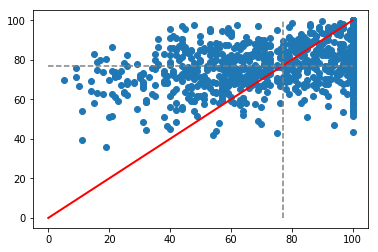

R2: 0.22, RMSE: 19.7, SCORE: 88 / 125 = 0.704
R2: 0.24, RMSE: 19.97, SCORE: 86 / 125 = 0.688
R2: 0.21, RMSE: 22.72, SCORE: 86 / 125 = 0.688
R2: 0.01, RMSE: 20.53, SCORE: 83 / 124 = 0.669
R2: 0.22, RMSE: 20.17, SCORE: 93 / 124 = 0.75
R2: 0.28, RMSE: 20.4, SCORE: 95 / 124 = 0.766
R2: 0.29, RMSE: 19.17, SCORE: 82 / 124 = 0.661
R2: 0.11, RMSE: 20.95, SCORE: 79 / 124 = 0.637
R2: 0.35, RMSE: 20.23, SCORE: 93 / 124 = 0.75
R2: 0.19, RMSE: 22.85, SCORE: 83 / 124 = 0.669

R2s:  0.21264672275564198
RMSEs:  20.669781057220955
scores:  0.6981999999999999
coef.corr:  0.47827875971248884
   negativo  positivo
0       173       611
1       257       202



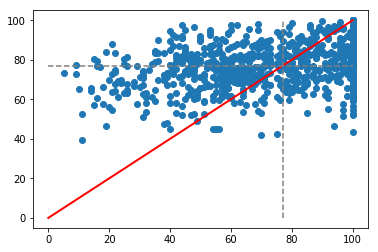

R2: 0.16, RMSE: 21.99, SCORE: 84 / 125 = 0.672
R2: 0.26, RMSE: 20.08, SCORE: 91 / 125 = 0.728
R2: 0.3, RMSE: 18.35, SCORE: 90 / 125 = 0.72
R2: 0.17, RMSE: 21.6, SCORE: 86 / 124 = 0.694
R2: 0.25, RMSE: 20.6, SCORE: 85 / 124 = 0.685
R2: 0.22, RMSE: 21.47, SCORE: 81 / 124 = 0.653
R2: 0.3, RMSE: 21.62, SCORE: 89 / 124 = 0.718
R2: 0.21, RMSE: 19.92, SCORE: 94 / 124 = 0.758
R2: 0.3, RMSE: 20.07, SCORE: 93 / 124 = 0.75
R2: 0.19, RMSE: 19.29, SCORE: 87 / 124 = 0.702

R2s:  0.23481757727307154
RMSEs:  20.498383107699546
scores:  0.708
coef.corr:  0.490377909095721
   negativo  positivo
0       169       619
1       261       194



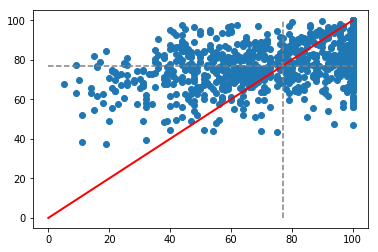

---------------------------------------------
RESUMEN:
r2: 0.2254200080913985
rsme: 20.574272560503946
score: 0.7052666666666667


,negativo,positivo
positivo,168.666667,615.333333
negativo,261.333333,197.666667


In [19]:
threshold = 77
all_r2 = []
all_rsme = []
all_score = []
all_aciertos_pos = []
all_aciertos_neg = []
all_errores_pos = []
all_errores_neg = []

for k in range(0, 3):
    r2s = []
    rmses =[]
    scores = []
    X=np.array(X)
    predictions_all = []
    aciertos_pos = []; aciertos_neg = []; errores_pos = []; errores_neg = []
    sum_ylist = 0; sum_pred = 0
    p = 0
    yy = []
    xx = []
    y_list_all = []
    X_list_all = []

    kf = KFold(n_splits=10, shuffle=True)
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        model = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, n_jobs=4)
        #model = MLPRegressor(activation='tanh', solver='sgd', learning_rate='adaptive', max_iter=900)
        #model = AdaBoostRegressor(base_estimator=None)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions = y_pred.copy()

        sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
        errores_positivo = 0; errores_negativo = 0
        sum_positivo = 0; sum_negativo = 0
        sum_predict_positivo = 0; sum_predict_negativo = 0
        total_test = len(X_test)
        X_list = list(X_test)
        y_list = list(y_test)

        for k in range(0, len(predictions)):
            sum += abs(predictions[k] - y_list[k])
            if y_list[k] >= threshold and predictions[k] >= threshold:
                aciertos_positivo += 1
            if y_list[k] >= threshold and predictions[k] < threshold:
                errores_positivo += 1
            if y_list[k] < threshold and predictions[k] < threshold:
                aciertos_negativo += 1
            if y_list[k] < threshold and predictions[k] >= threshold:
                errores_negativo += 1
            if y_list[k] >= threshold:
                sum_positivo += 1
            else:
                sum_negativo += 1
            if predictions[k] >= threshold:
                sum_predict_positivo += 1
            else:
                sum_predict_negativo += 1

        print "R2: " + str(round(r2_score(y_list, predictions), 2)) + ',',
        print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2)) + ',',
        print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
        df = pd.DataFrame({'real': y_list, 'prediction': predictions})

        aciertos_pos.append(aciertos_positivo)
        aciertos_neg.append(aciertos_negativo)
        errores_pos.append(errores_positivo)
        errores_neg.append(errores_negativo)

        r2s.append(r2_score(y_list, predictions))
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        scores.append(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))

        predictions_all.extend(predictions)
        X_list_all.extend(X_list)
        y_list_all.extend(y_list)

        sum_ylist += np.sum(y_list)
        sum_pred  += np.sum(predictions)

        p += 1

    print
    print "R2s: ", np.mean(r2s)
    print "RMSEs: ",np.mean(rmses)
    print "scores: ", np.mean(scores)
    print "coef.corr: " , np.corrcoef(y_list_all, predictions_all)[0][1]
    conf = pd.DataFrame([[np.sum(errores_neg), np.sum(aciertos_pos)], [np.sum(aciertos_neg), np.sum(errores_pos)]], columns=['negativo', 'positivo'])
    conf.rename(index={0:'negativo', 1:'positivo'})
    print conf
    print

    #for i in range(0, len(y_list_all)):
    #    if y_list_all[i] == 100 and predictions_all[i] < 60:
    #        print str(X_list_all[i]) + ' = ' + str(y_list_all[i]) + ' / ' + str(predictions_all[i])
    
    plt.scatter(y_list_all, predictions_all)
    plt.plot([0, 100], [0, 100], c='r', lw=2)
    ax = plt.gca()
    line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
    line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
    ax.add_line(line_h)
    ax.add_line(line_v)
    #x0 = [0, 0, 35, 35]
    #y0 = [0, threshold, threshold, 0]
    #ax.fill(x0, y0, alpha=0.2)
    plt.show()
    
    all_r2.append(np.mean(r2s))
    all_rsme.append(np.mean(rmses))
    all_score.append(np.mean(scores))
    all_aciertos_pos.append(np.sum(aciertos_pos))
    all_aciertos_neg.append(np.sum(aciertos_neg))
    all_errores_pos.append(np.sum(errores_pos))
    all_errores_neg.append(np.sum(errores_neg))

print '---------------------------------------------'
print 'RESUMEN:'
print "r2: " + str(np.mean(all_r2))
print "rsme: " + str(np.mean(all_rsme))
print "score: " + str(np.mean(all_score))

conf = pd.DataFrame([[np.mean(all_errores_neg), np.mean(all_aciertos_pos)], [np.mean(all_aciertos_neg), np.mean(all_errores_pos)]], columns=['negativo', 'positivo'])
conf.rename(index={0:'positivo', 1:'negativo'})